# FINAL PROJECT
## ANSHUMAN SARDA AND ARYAH RAO
ARYAH'S VERSION 

Before analysing the data, we need to import all the required modules.

In [1]:
# Import Modules
datadir = "data"

import os
import io
import sys
import importlib 
import json
import pandas as pd
from lxml import etree
import requests
from IPython.display import Image
import sqlalchemy as sa
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import math

module_path = os.path.abspath("modules")
if not module_path in sys.path:
    sys.path.append(module_path)

import util
importlib.reload(util)

htmlparser =  etree.HTMLParser()

%load_ext sql

Establish connection to the SQL database.

In [2]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

def buildConnectionString(source="sqlite_india"):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)

# Build the conection string
cstring = buildConnectionString("sqlite")
print("Connection string:", cstring)

# Connect to the database
%sql $cstring

Connection string: sqlite:///./dbfiles/india.db


## Import Table From SQL Database

Import the 'states' table from the SQL database.

In [3]:
# Display DataFrame from SQL
query = """
SELECT *
FROM states
"""

states = %sql $query
states = states.DataFrame()
states

 * sqlite:///./dbfiles/india.db
Done.


,state,population,CO,NH3,NO2,OZONE,PM10,PM2.5,SO2
0,Uttar Pradesh,199812341,44.875000,11.357143,32.375000,10.941176,134.250000,183.312500,16.750000
1,Maharashtra,112374333,42.500000,3.285714,38.714286,34.111111,124.875000,129.666667,22.428571
2,Bihar,104099452,56.900000,10.307692,60.388889,23.000000,227.529412,270.529412,14.000000
3,West Bengal,91276115,35.200000,5.800000,29.800000,12.800000,54.200000,38.000000,13.333333
4,Madhya Pradesh,72626809,35.538462,8.800000,37.357143,44.100000,145.500000,195.400000,25.000000
5,Rajasthan,68548437,42.750000,11.000000,52.625000,28.500000,113.375000,144.125000,12.875000
6,Karnataka,61095297,29.052632,3.937500,26.666667,20.400000,74.166667,72.388889,14.842105
7,Gujarat,60439692,68.800000,4.500000,51.666667,18.800000,132.000000,155.000000,27.000000
8,Andhra Pradesh,49577103,31.250000,2.750000,22.750000,24.000000,53.000000,56.500000,17.750000
9,Odisha,41974219,46.000000,7.500000,24.000000,12.000000,44.000000,26.000000,28.000000


## Analysing DataFrames

### Central Question:

What are states are affected by pollution in India? Is pollution correlated to population?

### Approach:
To determine which states are severely affected by pollution, we first create a threshold for healthy ozone levels and filter the states that have ozone levels below this threshold. These states are prone to holes in their ozone layers.

To determine if pollution and population are correlated, we plot a scatter plot to see if pollution increases as population increases.

Determine the ozone level threshold.

In [12]:
# Ozone threshold
query = """
SELECT 
  (AVG(OZONE) + MAX(OZONE) - AVG(OZONE)) / 2 AS ozone_threshold
FROM
  states
"""

ozone_threshold = %sql $query
ozone_threshold_df = ozone_threshold.DataFrame()
ozone_threshold_df

 * sqlite:///./dbfiles/india.db
Done.


,ozone_threshold
0,22.05


Filter states that have ozone levels below the threshold.

In [5]:
# Find states with ozone depletion below the threshold
query = """
SELECT state, OZONE
FROM states
WHERE OZONE < (
  SELECT (AVG(OZONE) + MAX(OZONE) - AVG(OZONE)) / 2 AS ozone_threshold
  FROM states
)
"""

depleted_ozone_states = %sql $query
depleted_ozone_states_df = depleted_ozone_states.DataFrame()
depleted_ozone_states_df

 * sqlite:///./dbfiles/india.db
Done.


,state,OZONE
0,Uttar Pradesh,10.941176
1,West Bengal,12.800000
2,Karnataka,20.400000
3,Gujarat,18.800000
4,Odisha,12.000000
5,Telangana,13.000000
6,Kerala,21.600000
7,Assam,10.000000
8,Punjab,16.666667
9,Haryana,19.217391


Plot the graph with the states below the threshold.

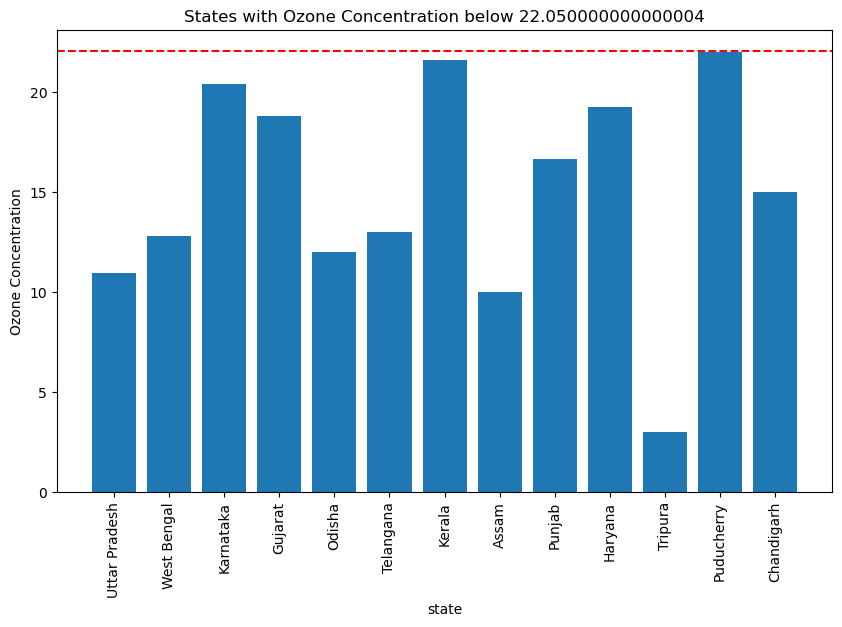

In [6]:
# Plot the depleted ozone states
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(depleted_ozone_states_df['state'], depleted_ozone_states_df['OZONE'])
ax.axhline(y=ozone_threshold_df['ozone_threshold'].values[0], color='r', linestyle='--')
ax.set_xlabel('state')
ax.set_ylabel('Ozone Concentration')
ax.set_title(f'States with Ozone Concentration below {ozone_threshold_df["ozone_threshold"].values[0]}')
plt.xticks(rotation=90)

# Show the graph
plt.show()

Uttar Pradesh, West Bengal, Karnataka, Gujarat, Odisha, Telangana, Kerala, Assam, Punjab, Haryana, Tripura, Puducherry, Chandigarh are the states that are prone to holes in their ozone layer.

Calculate avg_pollution as the average of all the "elements'" levels.

In [13]:
# Calculate avg_pollution
query = """
SELECT state, (CO + NH3 + NO2 + SO2)/4 as avg_pollution, population
FROM states
GROUP BY state
"""

avg_pollution = %sql $query
avg_pollution_df = avg_pollution.DataFrame()
avg_pollution_df

 * sqlite:///./dbfiles/india.db
Done.


,state,avg_pollution,population
0,Andhra Pradesh,18.625000,49577103
1,Assam,19.250000,31205576
2,Bihar,35.399145,104099452
3,Chandigarh,33.000000,1055450
4,Gujarat,37.991667,60439692
5,Haryana,23.594850,25351462
6,Karnataka,18.624726,61095297
7,Kerala,18.250000,33406061
8,Madhya Pradesh,26.673901,72626809
9,Maharashtra,26.732143,112374333


Determine state with the highest avg_pollution

In [8]:
# Highest avg_pollution state
query = """
SELECT state, avg_pollution, population
FROM (SELECT state, (CO + NH3 + NO2 + SO2)/4 as avg_pollution, population
        FROM states) 
WHERE avg_pollution = (SELECT MAX(avg_pollution)
                        FROM (
                        SELECT state, (CO + NH3 + NO2 + OZONE + SO2)/4 as avg_pollution 
                        FROM states))
"""

highest_pollution = %sql $query
highest_pollution = highest_pollution.DataFrame()
highest_pollution

 * sqlite:///./dbfiles/india.db
Done.


""


Determine state with the lowest avg_pollution

In [15]:
# Lowest avg_pollution state
query = """
SELECT state, avg_pollution, population
FROM (SELECT state, (CO + NH3 + NO2 + SO2)/4 as avg_pollution, population
        FROM states) 
WHERE avg_pollution = (SELECT MIN(avg_pollution)
                        FROM (
                        SELECT state, (CO + NH3 + NO2 + OZONE + SO2)/4 as avg_pollution 
                        FROM states))
"""

lowest_pollution = %sql $query
lowest_pollution = lowest_pollution.DataFrame()
lowest_pollution

 * sqlite:///./dbfiles/india.db
Done.


""


Plot scatter plot with pollution levels and population gradient.

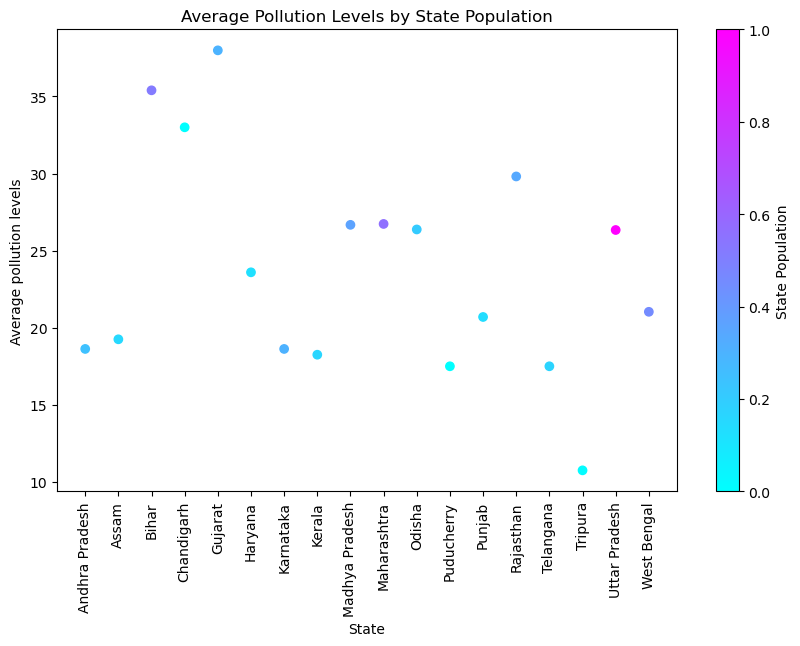

In [11]:
# Calculate the average pollution levels by state population
avg_pollution = avg_pollution_df["avg_pollution"].astype(float)
population = avg_pollution_df["population"].astype(float)
    
# Set color map and normalize color by population
cmap = plt.cm.get_cmap('cool')
norm = plt.Normalize(vmin=population.min(), vmax=population.max())
colors = norm(population)
    
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(range(len(avg_pollution)), avg_pollution, c=colors, cmap=cmap)
    
# Set xticks as state names
ax.set_xticks(range(len(avg_pollution)))
ax.set_xticklabels(avg_pollution_df["state"], rotation=90)
    
# Set labels and title
ax.set_xlabel("State")
ax.set_ylabel("Average pollution levels")
ax.set_title("Average Pollution Levels by State Population")
    
# Create colorbar and set label
cbar = plt.colorbar(sc)
cbar.set_label("State Population")
    
# Show the plot
plt.show()

As we can see, pollution and population are not directly proportionate.

## Conclusion

Based on the data, certain states in India have ozone levels that fall below the national threshold, which indicates a need for immediate policy changes. If there is a significant decrease in ozone levels in a particular area compared to surrounding areas, it could potentially result in an ozone hole formation, which is why the national threshold takes into account the ozone levels across India. 

Additionally, there is no evidence of a meaningful correlation between high population and pollution, which contradicts the claims made by the Indian government that pollution is solely due to a larger population. Therefore, India overall has high pollution levels and should prioritize implementing policy recommendations, particularly in states with ozone levels below the national threshold.